In [1]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

#read dattaset into data
data = pd.read_csv('Art Blocks.csv', header=0)

# convert time to ordinal
# TODO:enable to delete time by using regular expression
date = [str(t1).replace(' 00:00:00','') for t1 in data['DateTime']]
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in date]


# create list of observation data
#priceには'Sales USD'の列の値を用いる
#TODO:logで良いか確認
price = np.log(data['price_weekly_USD'].values)

vol = data['sum_vol90_BTC']
# create observations array (expected format for LPPLS observations)
#[time,price, vol]の配列を作る
observations = np.array([time, price, vol])

print(observations)


[[7.37756000e+05 7.37757000e+05 7.37758000e+05 ... 7.38142000e+05
  7.38143000e+05 7.38144000e+05]
 [1.08355254e+01 1.11949242e+01 1.13027691e+01 ... 1.65754532e+01
  1.66129014e+01 1.66737932e+01]
 [2.61557435e+03 5.26821509e+03 7.96171308e+03 ... 2.85283051e+06
  2.86012326e+06 2.86738707e+06]]


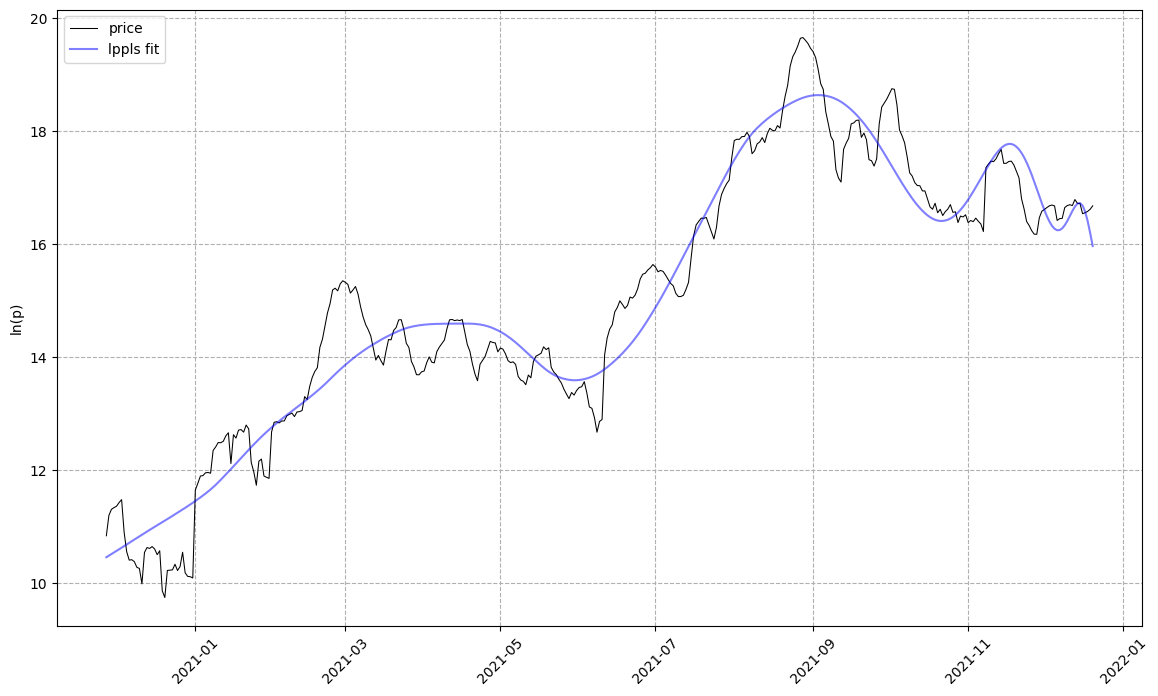

In [2]:
import lppls_factor
# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 200

# instantiate a new LPPLS model
# インスタンスを作成
lppls_model = lppls_factor.LPPLS_FACTOR(observations=observations)

# fit the model to the data and get back the params
# インスタンスのフィッティングメソッドを実行し、戻り値としてパラメータの値を得る
tc, m, w, a, b, c, c1, c2, d, O, D = lppls_model.fit(MAX_SEARCHES)



# visualize the fit
lppls_model.plot_fit()


N: 389
自由度調整済み決定係数 R2: 0.9350928146468787
F値: 5590.766527530781
RSS: 141.22744670283367
SSR: 2040.231735903979
SST: 2181.459182606111
a: -12.152197070393935
b: 0.6049576239099218
c1: -0.027832715206792754
c2: -0.06625738593364716
t_a: -4.228701171962115e-12
t_b: 27.011796633589228
t_c1: -13.919081914918568
t_c2: -27.908395614190823
t_d: 38.419088301303916
p_a: 0.9999999999966283
p_b: 0.0
p_c1: 0.0
p_c2: 0.0
p_d: 0.0
AIC: 717.8015598445854


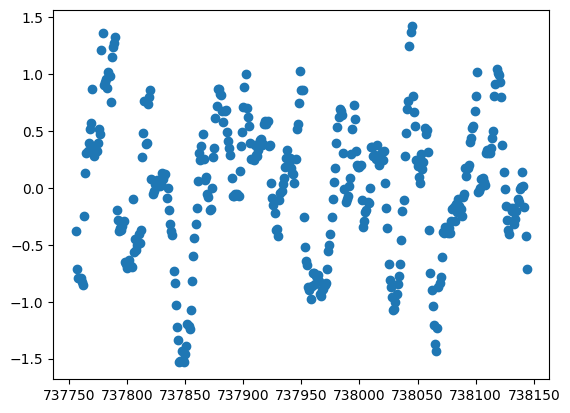

In [3]:
#TODO:決定係数の計算
#TODO:回帰式との誤差の二乗和を計算
N = len(observations[0])

k = 1
#推定された回帰式から得られた値
y_hat = [lppls_model.lppls_factor(t, v, tc, m, w, a, b, c1, c2, d) for t, v in zip(observations[0, :], observations[2, :])]
#残差：推定された回帰式から得られた値と観測データの値との差
E = np.subtract(y_hat, observations[1, :])
#squared residual
SE = np.power(E, 2)
#残差平方和　Residual Sum of Squares
SSE = np.sum(SE)
#誤差分散?
MSE = SSE / (N - k - 1)

#観測データの平均値
y_mean = np.mean(observations[1, :])
#回帰分散
regression = np.subtract(y_hat,y_mean)
SR = np.power(regression, 2)
SSR = np.sum(SR)
MSR = SSR / k

#全変動：観測データの分散
toal = np.subtract(y_mean, observations[1, :])
ST = np.power(toal, 2)
SST = np.sum(ST)
MST = SST / (N-1)
R2 = 1 - (MSE / MST)
F = MSR / MSE

def f(t, tc, m, w, a, b, c1, c2):
    return  np.power(tc - t, m)

def g(t, tc, m, w, a, b, c1, c2):
    return  np.power(tc - t, m) * np.cos(w * np.log(tc - t))
    
def h(t, tc, m, w, a, b, c1, c2):
    return  np.power(tc - t, m) * np.sin(w * np.log(tc - t))
    
Xc = [a] * N
Xf = [f(t, tc, m, w, a, b, c1, c2) for t, v in zip(observations[0, :], observations[2, :]) ]
Xg = [g(t, tc, m, w, a, b, c1, c2) for t, v in zip(observations[0, :], observations[2, :]) ]
Xh = [h(t, tc, m, w, a, b, c1, c2) for t, v in zip(observations[0, :], observations[2, :]) ]
Xi = vol

X = np.c_[Xc, Xf, Xg, Xh, Xi] 
X_error = (X - X.mean(axis=0))
s = np.dot(X_error.T, X_error)
s = np.linalg.inv(s)

std_error = np.sqrt(np.diagonal(MSE * s))

t_a = a / std_error[0]
t_b = b / std_error[1]
t_c1 = c1 / std_error[2]
t_c2 = c2 / std_error[3]
t_d = d / std_error[4]

p_a = 2 * (1-stats.t.cdf(np.abs(t_a),N-k-1))
p_b = 2 * (1-stats.t.cdf(np.abs(t_b),N-k-1))
p_c1 = 2 * (1-stats.t.cdf(np.abs(t_c1),N-k-1))
p_c2 = 2 * (1-stats.t.cdf(np.abs(t_c2),N-k-1))
p_d = 2 * (1-stats.t.cdf(np.abs(t_d),N-k-1))

#TODO:AICを計算
AIC = N * np.log(2 * np.pi ) + N * np.log(MSE) + N + 2 * (k + 2)

print('N: ' + str(N))
print("自由度調整済み決定係数 R2: " + str(R2))
print("F値: " + str(F))
print("RSS: " + str(SSE))
print("SSR: " + str(SSR))
print("SST: " + str(SST))
print('a: ' + str(a))
print('b: ' + str(b))
print('c1: ' + str(c1))
print('c2: ' + str(c2))
print('t_a: ' + str(t_a))
print('t_b: ' + str(t_b))
print('t_c1: ' + str(t_c1))
print('t_c2: ' + str(t_c2))
print('t_d: ' + str(t_d))
print('p_a: ' +str(p_a))
print('p_b: ' +str(p_b))
print('p_c1: ' +str(p_c1))
print('p_c2: ' +str(p_c2))
print('p_d: ' +str(p_d))
print("AIC: " + str(AIC))

plt.scatter(observations[0],E)
plt.show()


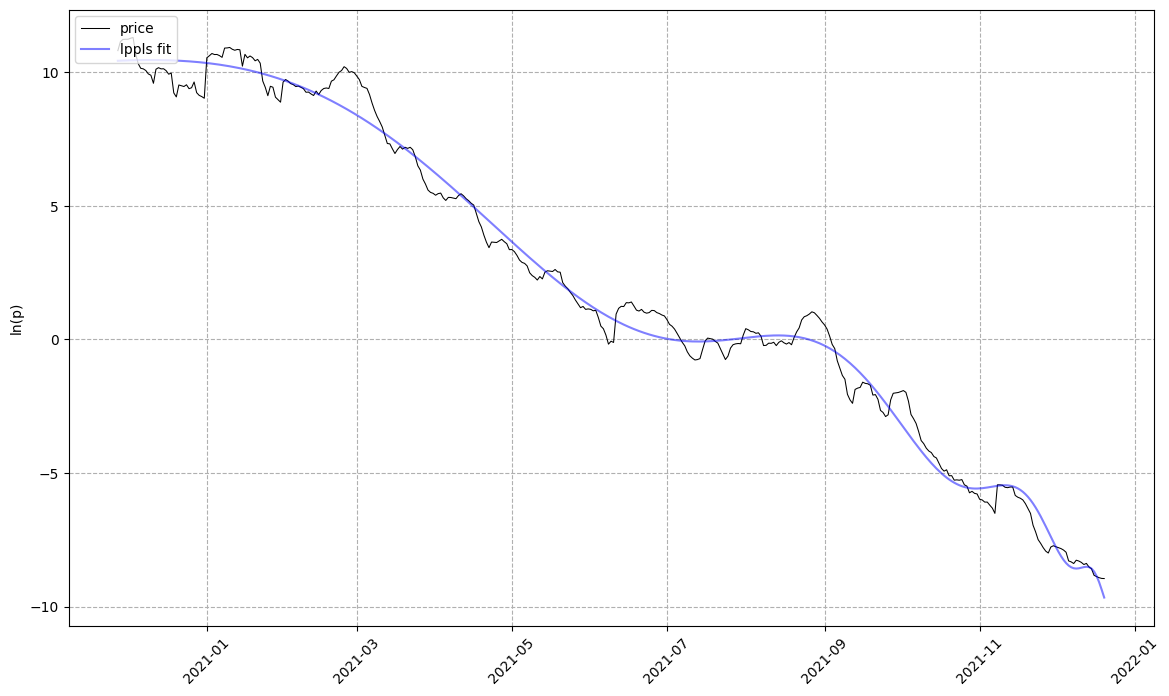

In [4]:
import lppls_original

#観測データから外的な影響を取り除く
external_effect = d * observations[2, :]
internal_effect = np.subtract(observations[1, :], external_effect)
observations_internal = np.array([time, internal_effect])

#外的な影響を取り除いたデータについてconfidence indicatorを算出する
# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 250

# instantiate a new LPPLS model
# インスタンスを作成
lppls_model_internal = lppls_original.LPPLS(observations=observations_internal)

# fit the model to the data and get back the params
# インスタンスのフィッティングメソッドを実行し、戻り値としてパラメータの値を得る
tc_in, m_in, w_in, a_in, b_in, c_in, c1_in, c2_in, O_in, D_in = lppls_model_internal.fit(MAX_SEARCHES)

# visualize the fit
lppls_model_internal.plot_fit()


100%|██████████| 270/270 [01:06<00:00,  4.09it/s]


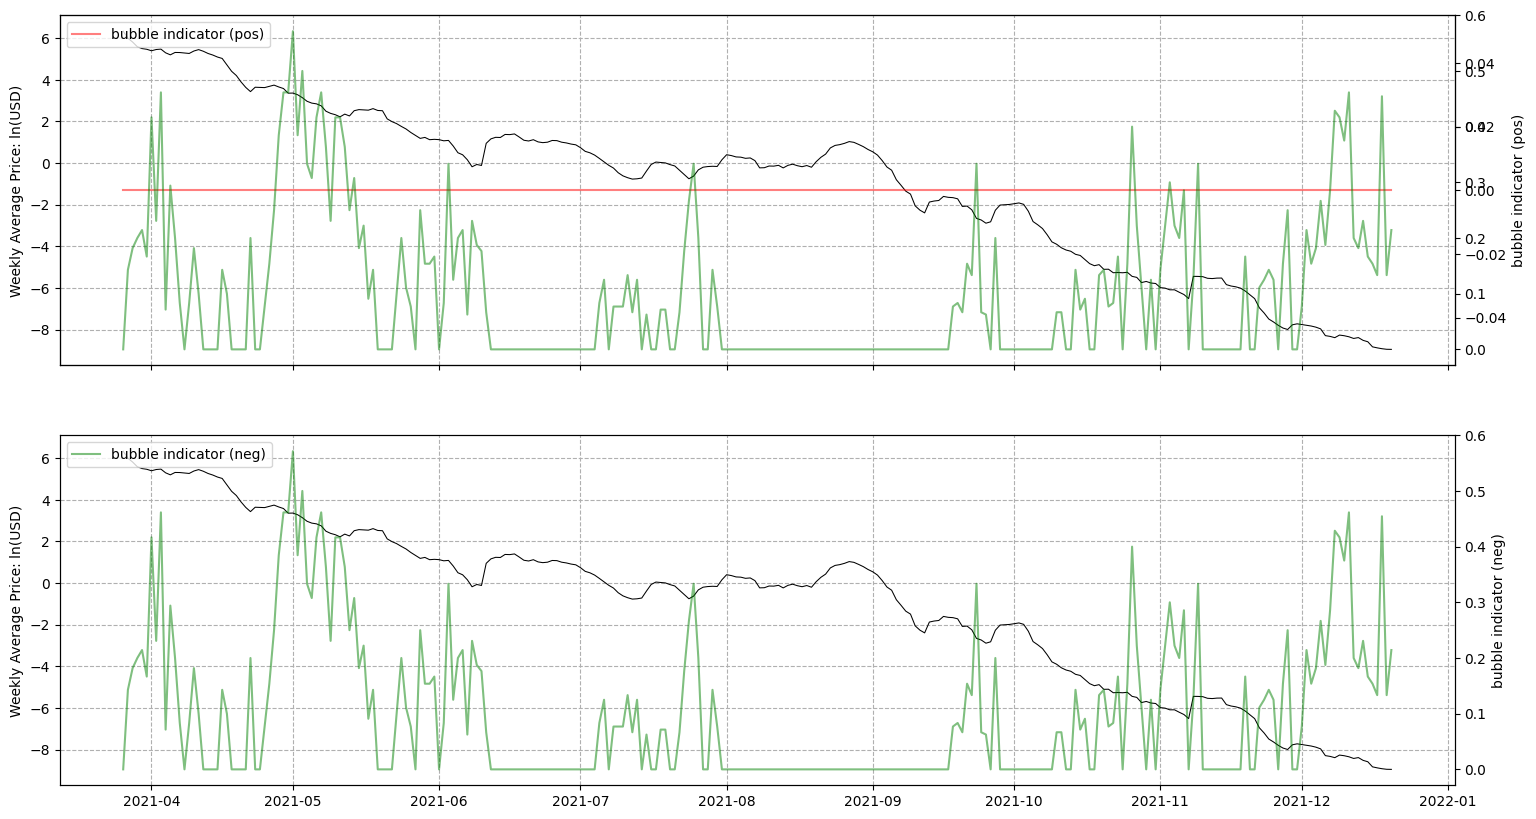

In [5]:
# compute the confidence indicator
res = lppls_model_internal.mp_compute_nested_fits(
    workers=8,#TODO:何?
    window_size=120,
    smallest_window_size=30,
    outer_increment=1,
    inner_increment=5,
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)

lppls_model_internal.plot_confidence_indicators_2(res)
# should give a plot like the following...

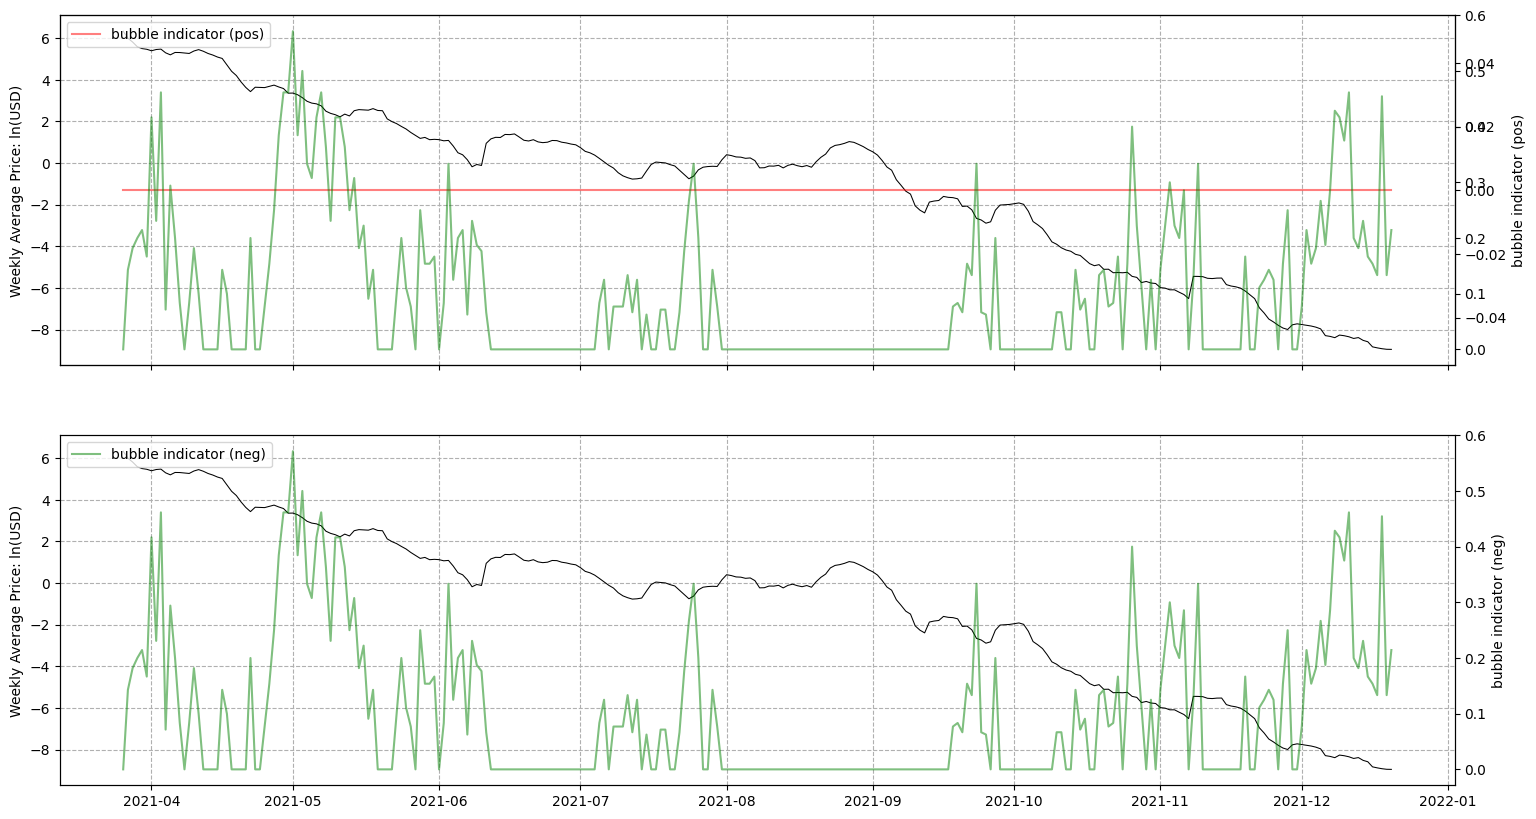

In [6]:

lppls_model_internal.plot_confidence_indicators_2(res)